In [1]:
import gpr

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

W0713 00:16:59.607571 140533673363264 logger.py:200] AstropyDeprecationWarning: astropy.extern.six will be removed in 4.0, use the six module directly if it is still needed


In [2]:
thetaS = np.array([250, 0.1, 0.4, np.pi/6])

GP = gpr.GPR(verbose=True, random_state=0)
# GP.extract_exposure('/data4/paper/fox/DES/austinFull.fits', 500)
GP.gen_synthetic_data(2000, thetaS)
GP.remove_outliers(3)
GP.split_data(0.20)
GP.white_cov()
GP.fit(thetaS)

Generating synthetic data...
Removing data points that have residuals greater than 3 standard deviations from the mean...
100.0% of data points are being kept.
Splitting data into training and testing sets...
Generating white noise covariance function...
Generating elliptical covariance function...
Solving for posterior...


Current Log Marginal Likelihood: -619.0563860061956
Fraction of test points within 1 standard deviation(s) of posterior predictive mean:
dx: 0.96; dy: 0.96
Chisq dx: 3.9979027897884656
Chisq d1: 3.407575738665111


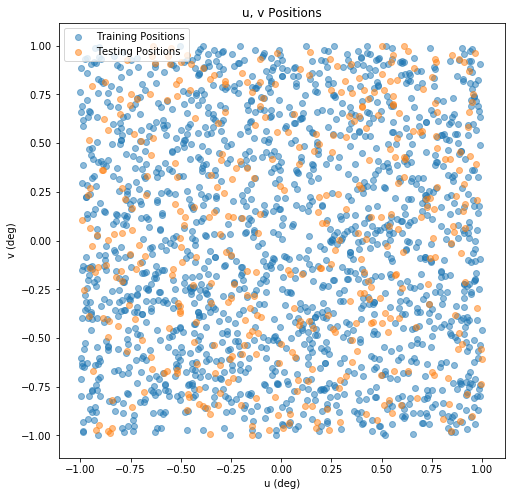

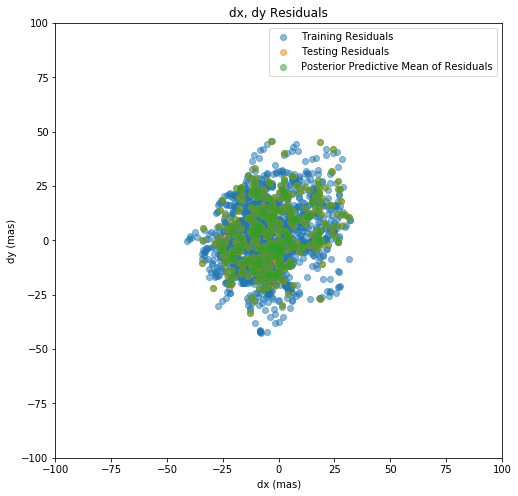

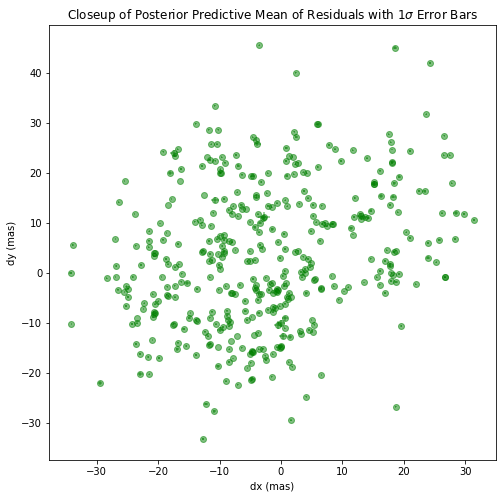

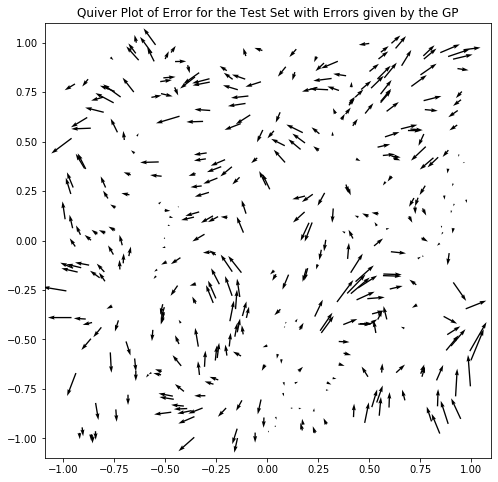

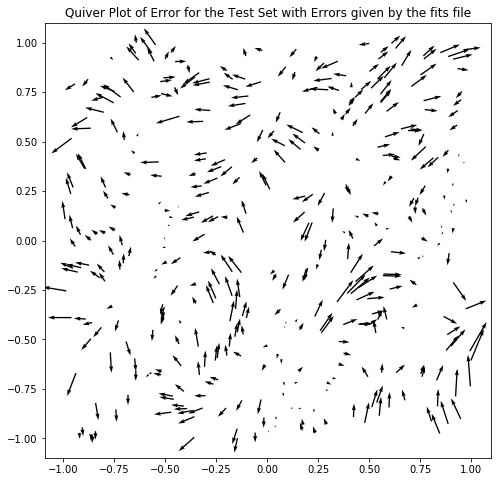

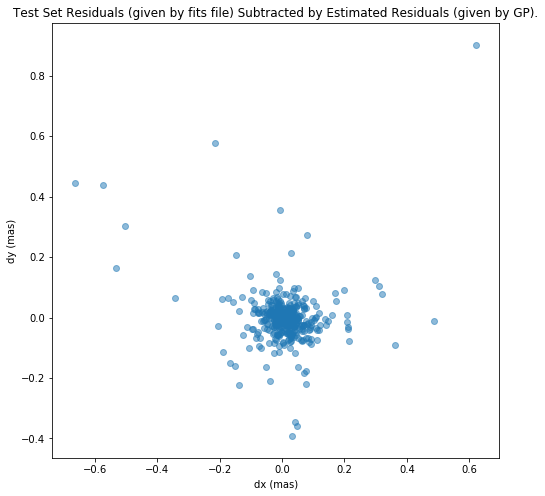

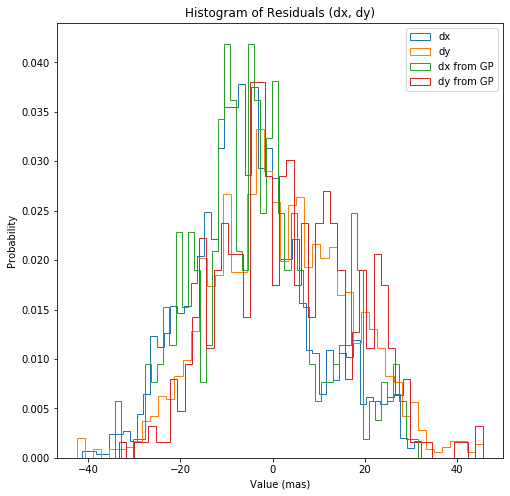

In [3]:
GP.summary()

In [4]:
def LML(theta, GP=GP, verbose=True):
    if verbose: print(theta)

    GP.fit(theta)
    LML = GP.get_nLML(positive=True)
    return LML

In [5]:
GP.verbose = False
bounds = np.array([(1, 1e3), (1e-3, 100), (1e-3, 100), (-np.inf, np.inf)])
theta0 = np.array([100, 1, 1, 0])
result = minimize(LML, theta0, method='L-BFGS-B', bounds=bounds, options={'eps': 0.01})

print()
print(result.x)
print(thetaS)

[100.   1.   1.   0.]
[100.01   1.     1.     0.  ]
[100.     1.01   1.     0.  ]
[100.     1.     1.01   0.  ]
[1.e+02 1.e+00 1.e+00 1.e-02]
[100.99999877   0.99889      0.99889      0.        ]
[101.00999877   0.99889      0.99889      0.        ]
[100.99999877   1.00889      0.99889      0.        ]
[100.99999877   0.99889      1.00889      0.        ]
[1.00999999e+02 9.98890001e-01 9.98890001e-01 1.00000000e-02]
[104.99999384   0.99445001   0.99445001   0.        ]
[105.00999384   0.99445001   0.99445001   0.        ]
[104.99999384   1.00445001   0.99445001   0.        ]
[104.99999384   0.99445001   1.00445001   0.        ]
[1.04999994e+02 9.94450007e-01 9.94450007e-01 1.00000000e-02]
[120.99997413   0.97669003   0.97669003   0.        ]
[121.00997413   0.97669003   0.97669003   0.        ]
[120.99997413   0.98669003   0.97669003   0.        ]
[120.99997413   0.97669003   0.98669003   0.        ]
[1.20999974e+02 9.76690029e-01 9.76690029e-01 1.00000000e-02]
[ 9.77676620e+01  1.0000

Current Log Marginal Likelihood: -662.3611926154481
Fraction of test points within 1 standard deviation(s) of posterior predictive mean:
dx: 0.965; dy: 0.965
Chisq dx: 4.255832011084576
Chisq d1: 4.306239803350937


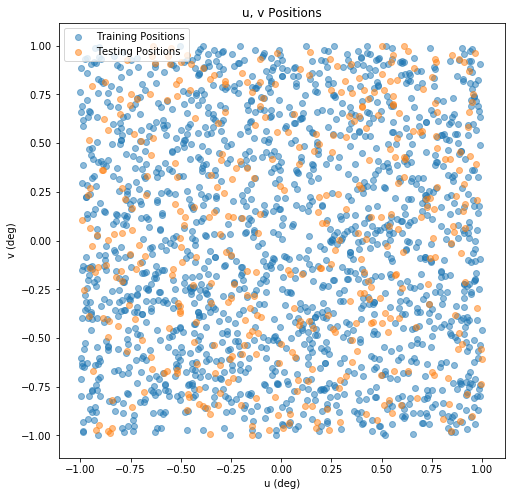

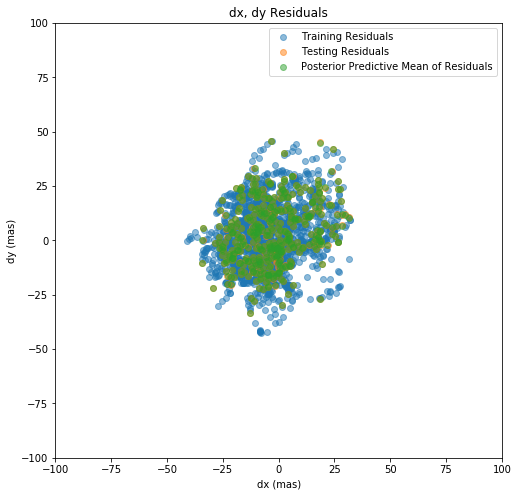

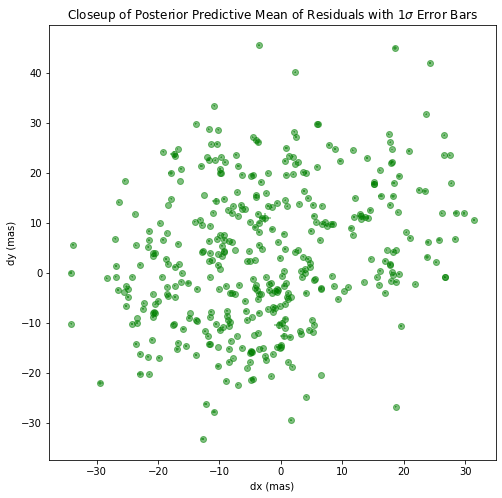

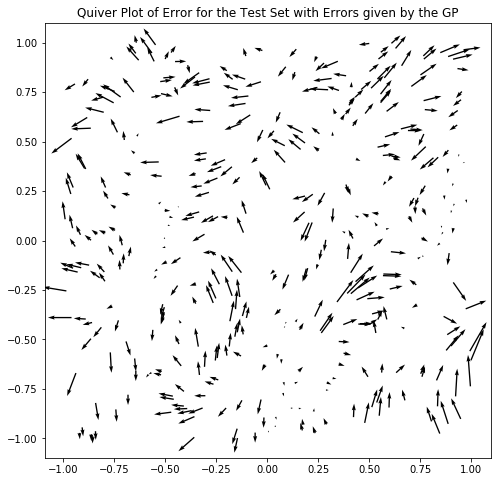

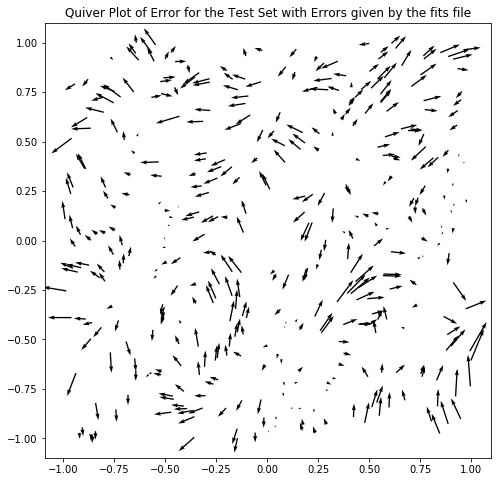

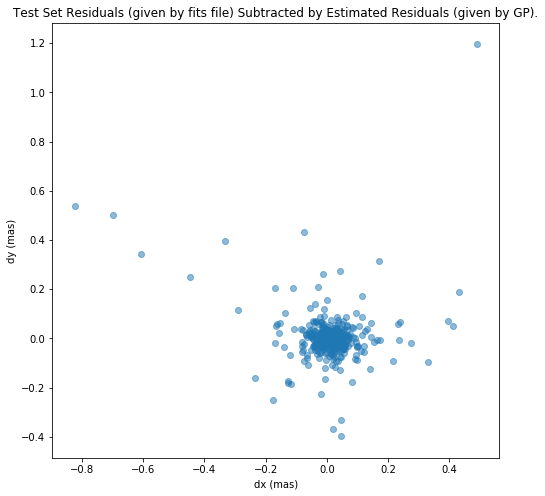

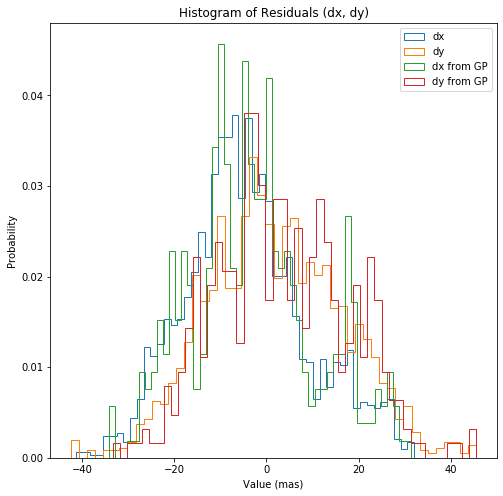

In [6]:
GP.fit(result.x)
GP.summary()